In [4]:
import torch
import torch.nn as nn
import numpy as np
import sys 
import optuna 
import pandas as pd
import pickle

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')
import matplotlib as mpl
print(mpl.style.available)
mpl.style.use('seaborn-talk')

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [6]:
data_dir = '/afs/csail.mit.edu/u/z/zeshanmh/research/longlearn/data/ml_mmrf/ml_mmrf/output/1_mmrf_dataset_2mos_type.pkl'
with open(data_dir, 'rb') as f:
    dset = pickle.load(f)
print(dset.keys())

dict_keys(['treatment', 'labs', 'baseline', 'os', 'pfs_nonasct', 'pfs_asct', 'pfs', 'trt_outcomes'])


In [7]:
dset['os']

{'pids': array(['MMRF_1014', 'MMRF_1024', 'MMRF_1033', ..., 'MMRF_2754',
        'MMRF_2781', 'MMRF_2840'], dtype=object),
 'data': array([19.766666666666666, 40.85, 38.35, ..., 0.13333333333333333,
        3.466666666666667, 0.4166666666666667], dtype=object),
 'obs': array([0, 0, 0, ..., 1, 1, 1], dtype=object),
 'names': array(['overall_survival'], dtype='<U16')}

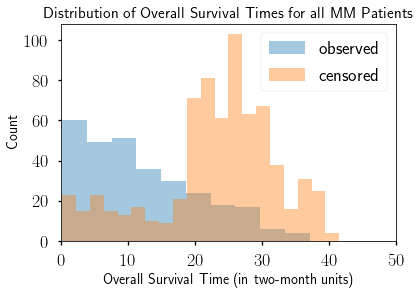

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.distplot(dset['os']['data'][dset['os']['obs']==1],label='observed', ax = ax, kde=False)
sns.distplot(dset['os']['data'][dset['os']['obs']==0],label='censored', ax = ax, kde=False)
ax.legend(fontsize=18)
ax.set_xlim([0,50])
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_title('Distribution of Overall Survival Times for all MM Patients')
ax.set_ylabel('Count')
ax.set_xlabel('Overall Survival Time (in two-month units)')
fig.savefig('./hist_os.pdf',bbox_inches='tight')

In [22]:
print(dset['os']['data'].shape)
print(f"number of observed patients with OS time: {np.sum(dset['os']['obs'])}")
print(f"number of censored patients with OS time: {np.where(dset['os']['obs'] == 0.)[0].shape[0]}")


(1001,)
number of observed patients with OS time: 295
number of observed patients with OS time: 706


In [27]:
print(dset['pfs_nonasct']['data'].shape)
print(f"number of observed patients (non-ASCT) with PFS time: {np.sum(dset['pfs_nonasct']['obs'])}")
print(f"number of censored patients (non-ASCT) with PFS time: {np.where(dset['pfs_nonasct']['obs'] == 0.)[0].shape[0]}")

(501,)
number of observed patients (non-ASCT) with PFS time: 382
number of censored patients (non-ASCT) with PFS time: 119


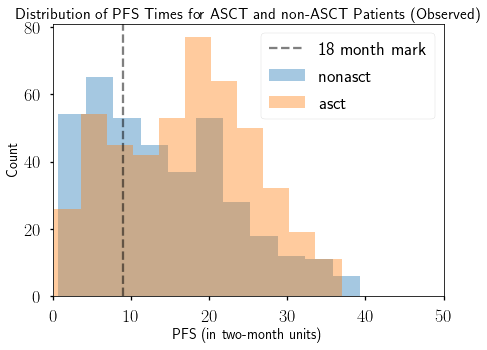

In [68]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
dobs = np.copy(dset['pfs_nonasct']['data'][dset['pfs_nonasct']['obs']==1])
dobs_as = np.copy(dset['pfs_asct']['data'][dset['pfs_asct']['obs']==1])
# print(dobs[dobs<10].shape)
ax.axvline(x=9,color='k',linestyle='--', alpha=0.5, label='18 month mark')
sns.distplot(dobs,label='nonasct', ax = ax, kde=False)
sns.distplot(dobs_as,label='asct', ax = ax, kde=False)
# sns.distplot(dset['pfs_nonasct']['data'][dset['pfs_nonasct']['obs']==0],label='censored', ax = ax, kde=False)
ax.legend(fontsize=18)
ax.set_xlim([0,50])
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_title('Distribution of PFS Times for ASCT and non-ASCT Patients (Observed)')
ax.set_ylabel('Count')
ax.set_xlabel('PFS (in two-month units)')
fig.savefig('./hist_pfs_nonasct.pdf',bbox_inches='tight')


In [29]:
print(dset['pfs_asct']['data'].shape)
print(f"number of observed patients (ASCT) with PFS time: {np.sum(dset['pfs_asct']['obs'])}")
print(f"number of censored patients (ASCT) with PFS time: {np.where(dset['pfs_asct']['obs'] == 0.)[0].shape[0]}")

(600,)
number of observed patients (ASCT) with PFS time: 473
number of censored patients (ASCT) with PFS time: 127


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
dobs = np.copy(dset['pfs_asct']['data'][dset['pfs_nonasct']['obs']==1])
# print(dobs[dobs<10].shape)
# ax.axvline(x=9,color='k',linestyle='--', alpha=0.5, label='18 month mark')
sns.distplot(dobs,label='observed', ax = ax, kde=False)
# sns.distplot(dset['pfs_nonasct']['data'][dset['pfs_nonasct']['obs']==0],label='censored', ax = ax, kde=False)
ax.legend(fontsize=18)
# ax.set_xlim([0,70])
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_title('Distribution of PFS Times for ASCT Patients')
ax.set_ylabel('Count')
ax.set_xlabel('Overall Survival Time (in two-month units)')
fig.savefig('./hist_pfs_nonasct.pdf',bbox_inches='tight')
